This is a notebook for examining full annotations. 

A few notes: 

    1) We work only with annotations for datasets we also have registered dff volumes for

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from janelia_core.math.basic_functions import find_disjoint_intervals
from janelia_core.math.basic_functions import copy_and_delay

from keller_zlatic_vnc.data_processing import count_transitions
from keller_zlatic_vnc.data_processing import count_unique_subjs_per_transition
from keller_zlatic_vnc.data_processing import generate_standard_id_for_full_annots
from keller_zlatic_vnc.data_processing import generate_standard_id_for_volume
from keller_zlatic_vnc.data_processing import match_standard_subject_ids
from keller_zlatic_vnc.data_processing import get_basic_clean_annotations_from_full
from keller_zlatic_vnc.data_processing import read_full_annotations

In [3]:
pd.set_option('display.max_rows', 300)

## Parameters go here

In [4]:
# Folders containing a4 and a9 annotation data
a4_annot_folder = r'\\dm11\bishoplab\projects\keller_vnc\data\full_annotations\behavior_csv_cl_A4'
a9_annot_folder = r'\\dm11\bishoplab\projects\keller_vnc\data\full_annotations\behavior_csv_cl_A9'
spont_only_annot_folder = r'\\dm11\bishoplab\projects\keller_vnc\data\full_annotations\spontaneous_only_annotations'

# File containing locations to registered volumes
volume_loc_file = r'\\dm11\bishoplab\projects\keller_vnc\data\experiment_data_locations.xlsx'

# List subjects we do not want to include in the analysis
exclude_subjs = set(['CW_17-11-06-L2'])

## Get list of all annotation files for which we also have registered volumes

In [5]:
# Get names of all annotation files
annot_file_paths = (glob.glob(str(Path(a4_annot_folder) / '*.csv')) + glob.glob(str(Path(a9_annot_folder) / '*.csv')) +
                    glob.glob(str(Path(spont_only_annot_folder) / '*.csv')))
annot_file_names = [Path(p).name for p in annot_file_paths]
annot_subjs = [generate_standard_id_for_full_annots(fn) for fn in annot_file_names]

In [6]:
# Read in location of all registered volumes
def c_fcn(str):
    return str.replace("'", "")
converters = {0:c_fcn, 1:c_fcn}

volume_locs = pd.read_excel(volume_loc_file, header=1, usecols=[1, 2], converters=converters)
volume_subjs = [generate_standard_id_for_volume(volume_locs.loc[i,'Main folder'], 
                                                       volume_locs.loc[i,'Subfolder'])  for i in volume_locs.index]

In [7]:
# Update name of one of the volume subjects to match the annotations (this is only needed for one subject)
m_ind = np.argwhere(np.asarray(volume_subjs) == 'CW_17-11-03-L6')[0][0]
volume_subjs[m_ind] = 'CW_17-11-03-L6-2'

In [8]:
# See which subjects we have both annotations and registered volumes for
possible_volume_subjs = set(volume_subjs) - exclude_subjs
keep_annot_subjs = [True if s_id in possible_volume_subjs else False for s_id in annot_subjs]

## Read in the annotations for each analysis subject

In [9]:
annotations = []
for i in range(len(keep_annot_subjs)):
    if keep_annot_subjs[i] == True:
        tbl = read_full_annotations(annot_file_paths[i])
        tbl['subject_id'] = annot_subjs[i]
        annotations.append(tbl)

## Get clean annotations with basic supplemental information

In [10]:
clean_annotations = []
for annot in annotations:
    clean_annotations.append(get_basic_clean_annotations_from_full(annot))

## Now put everything together into a single table

In [11]:
all_clean_annots = pd.concat(clean_annotations, ignore_index=True)

## Now find a value of transition times for which we declare quiet transitions

In [34]:
trans_perc = 10

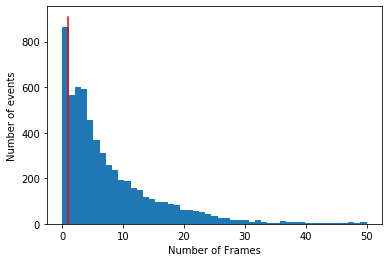

In [35]:
t_in = (all_clean_annots['start'] - all_clean_annots['beh_before_end']).to_numpy()
quiet_th = np.percentile(t_in, trans_perc)

max_n_frames = 50
plt.figure()
_ = plt.hist(t_in, bins=np.linspace(0, max_n_frames, max_n_frames))
plt.plot([quiet_th, quiet_th], [0, plt.gca().get_ylim()[1]], 'r-')
_ = plt.xlabel('Number of Frames')
_ = plt.ylabel('Number of events')

In [36]:
quiet_th

1.0

## Now we apply our criteria to mark different transitions as quiet


In [37]:
all_clean_annots.loc[(all_clean_annots['start'] - all_clean_annots['beh_before_end']) > quiet_th, 'beh_before'] = 'Q'
all_clean_annots.loc[(all_clean_annots['beh_after_start'] - all_clean_annots['end']) > quiet_th, 'beh_after'] = 'Q'

## Now we see how many subjects showed each type of transition 

Rows are behaviors we transition from and columns are behaviors we transition to

We are looking at transitions *into* the events of interst - which is why there are no transitions into quiet (since there are no quiet events of interst)

In [38]:
count_unique_subjs_per_transition(all_clean_annots, before_str='beh_before', after_str='beh')

,B,F,H,O,P,Q,TL,TR
B,4.0,0.0,10.0,0.0,1.0,0.0,20.0,20.0
F,0.0,21.0,4.0,0.0,12.0,0.0,4.0,9.0
H,7.0,2.0,3.0,1.0,1.0,0.0,31.0,30.0
O,1.0,13.0,2.0,0.0,5.0,0.0,1.0,4.0
P,2.0,25.0,10.0,2.0,2.0,0.0,15.0,15.0
Q,37.0,61.0,52.0,35.0,54.0,0.0,59.0,58.0
TL,21.0,10.0,10.0,2.0,6.0,0.0,1.0,23.0
TR,25.0,17.0,9.0,1.0,4.0,0.0,20.0,0.0


## Now we see how many events showed each type of transition

Rows are behaviors we transition from and columns are behaviors we transition to

In [39]:
count_transitions(all_clean_annots, before_str='beh_before', after_str='beh')

,B,F,H,O,P,Q,TL,TR
B,6.0,0.0,20.0,0.0,1.0,0.0,45.0,40.0
F,0.0,72.0,20.0,0.0,18.0,0.0,5.0,9.0
H,15.0,2.0,3.0,1.0,1.0,0.0,63.0,64.0
O,1.0,26.0,2.0,0.0,5.0,0.0,1.0,4.0
P,3.0,87.0,10.0,2.0,2.0,0.0,19.0,19.0
Q,290.0,3304.0,198.0,96.0,460.0,0.0,539.0,509.0
TL,47.0,16.0,14.0,4.0,7.0,0.0,1.0,54.0
TR,79.0,24.0,13.0,1.0,4.0,0.0,36.0,0.0


## Remove columns which are no longer needed and view the raw table

In [ ]:
all_clean_annots.drop(['beh_before_start', 'beh_before_end', 'beh_after_start', 'beh_after_end'], 
                      axis=1, inplace=True)

In [ ]:
all_clean_annots[all_clean_annots['subject_id'] == 'CW_17-11-27-L4']

In [ ]:
np.sort(all_clean_annots['subject_id'].unique())

## Debug code

In [ ]:
annotations[10]